In [5]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt


In [6]:
def initialize():
    """
    Create a Watts–Strogatz small-world network with:
    - 50 nodes
    - k_nearest at 4
    - node voltages around 1.0 ± 0.1
    - link conductances around 1.0 ± 10%
    """
    # ----- network size -----
    n_nodes = 50
    k_nearest = 4         # fixed, meets assignment requirements
    rewiring_prob = 0.1   # reasonable small-world value

    # ----- build the graph -----
    G = nx.watts_strogatz_graph(n_nodes, k_nearest, rewiring_prob, seed=42)

    # ----- assign node voltages -----
    for node in G.nodes():
        G.nodes[node]['voltage'] = 1.0 + random.uniform(-0.1, 0.1)

    # ----- assign link conductances -----
    for u, v in G.edges():
        G[u][v]['conductance'] = 1.0 + random.uniform(-0.1, 0.1)

    return G


In [7]:
def update(G, alpha, beta, gamma):
    """
    Do one time-step update of voltages and conductances.

    alpha : voltage adaptation rate
    beta  : reinforcement rate
    gamma : decay rate
    """
    # ---- copy old voltages and conductances ----
    old_voltage = {}
    for node in G.nodes():
        old_voltage[node] = G.nodes[node]['voltage']

    old_conductance = {}
    for u, v in G.edges():
        old_conductance[(u, v)] = G[u][v]['conductance']

    # ---- update node voltages ----
    for node in G.nodes():
        neighbors = list(G.neighbors(node))

        # if no neighbors, keep voltage the same
        if len(neighbors) == 0:
            continue

        # average neighbor voltage
        total = 0.0
        for nb in neighbors:
            total += old_voltage[nb]
        neighbor_avg = total / float(len(neighbors))

        # move a fraction alpha toward neighbor average
        current_v = old_voltage[node]
        new_v = current_v + alpha * (neighbor_avg - current_v)
        G.nodes[node]['voltage'] = new_v

    # ---- update link conductances ----
    for u, v in G.edges():
        g_old = old_conductance[(u, v)]

        # voltage difference on this line
        dv = abs(old_voltage[u] - old_voltage[v])

        # reinforcement (beta * dv) and decay (-gamma)
        g_new = g_old + beta * dv - gamma

        # keep conductance positive
        if g_new < 1e-4:
            g_new = 1e-4

        G[u][v]['conductance'] = g_new


In [8]:
def run_simulation(T, alpha, beta, gamma):
    # create the starting network
    G = initialize()

    avg_conductance_history = []
    voltage_spread_history = []

    # run T time steps
    for t in range(T):

        # ---- compute average conductance ----
        conductances = []
        for u, v in G.edges():
            conductances.append(G[u][v]['conductance'])

        avg_cond = sum(conductances) / len(conductances)
        avg_conductance_history.append(avg_cond)

        # ---- compute spread in voltages ----
        voltages = []
        for n in G.nodes():
            voltages.append(G.nodes[n]['voltage'])

        # compute standard deviation
        mean_v = sum(voltages) / len(voltages)

        total = 0.0
        for v in voltages:
            total += (v - mean_v) ** 2
        spread = (total / len(voltages)) ** 0.5

        voltage_spread_history.append(spread)

        # ---- update the network ----
        update(G, alpha, beta, gamma)

    return avg_conductance_history, voltage_spread_history

In [9]:
def plot_results(avg_conductance, voltage_spread):
    steps = range(len(avg_conductance))

    # first plot
    plt.figure()
    plt.plot(steps, avg_conductance)
    plt.xlabel("Time step")
    plt.ylabel("Average Conductance")
    plt.title("Average Conductance Over Time")
    plt.tight_layout()

    # second plot
    plt.figure()
    plt.plot(steps, voltage_spread)
    plt.xlabel("Time step")
    plt.ylabel("Voltage Spread")
    plt.title("Voltage Spread Over Time")
    plt.tight_layout()

    plt.show()


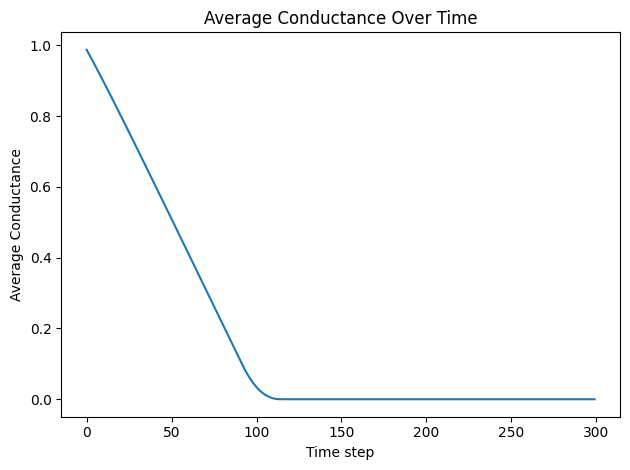

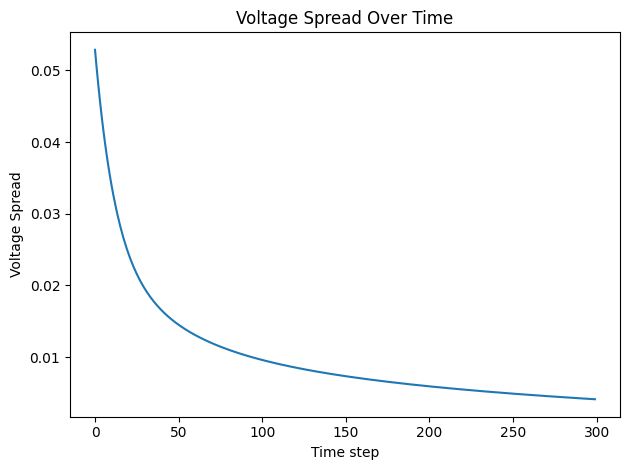

In [11]:
avg_cond, volt_spread = run_simulation(
    T=300,
    alpha=0.05,
    beta=0.02,
    gamma=0.01
)

plot_results(avg_cond, volt_spread)

In [12]:
# ------------------ Parameter Testing ------------------ #

def test_parameter(parameter_name, values, T=300):
    """
    Test the effect of one parameter (alpha, beta, or gamma)
    by running several simulations with different values.
    """
    results = []   # will store (value, avg_cond, volt_spread)

    for val in values:
        print("Running", parameter_name, "=", val)

        # default values
        alpha = 0.05
        beta = 0.02
        gamma = 0.01

        # replace only the parameter we are testing
        if parameter_name == "alpha":
            alpha = val
        elif parameter_name == "beta":
            beta = val
        elif parameter_name == "gamma":
            gamma = val

        # run the simulation
        avg_cond, volt_spread = run_simulation(
            T=T,
            alpha=alpha,
            beta=beta,
            gamma=gamma
        )

        results.append((val, avg_cond, volt_spread))

    return results

In [13]:
# ---- Plotting function for parameter effects ---- #
def plot_parameter_effect(results, parameter_name):
    """
    Plot the effect of changing one parameter.
    results = list of (value, avg_cond_list, volt_spread_list)
    """
    steps = range(len(results[0][1]))

    # --- Plot average conductance ---
    plt.figure()
    for value, avg_cond, _ in results:
        plt.plot(steps, avg_cond, label=f"{parameter_name}={value}")
    plt.xlabel("Time step")
    plt.ylabel("Average Conductance")
    plt.title("Effect of " + parameter_name + " on Conductance")
    plt.legend()
    plt.tight_layout()

    # --- Plot voltage spread ---
    plt.figure()
    for value, _, volt_spread in results:
        plt.plot(steps, volt_spread, label=f"{parameter_name}={value}")
    plt.xlabel("Time step")
    plt.ylabel("Voltage Spread")
    plt.title("Effect of " + parameter_name + " on Voltage Stability")
    plt.legend()
    plt.tight_layout()

    plt.show()

Running alpha = 0.01
Running alpha = 0.03
Running alpha = 0.05
Running alpha = 0.08
Running alpha = 0.1


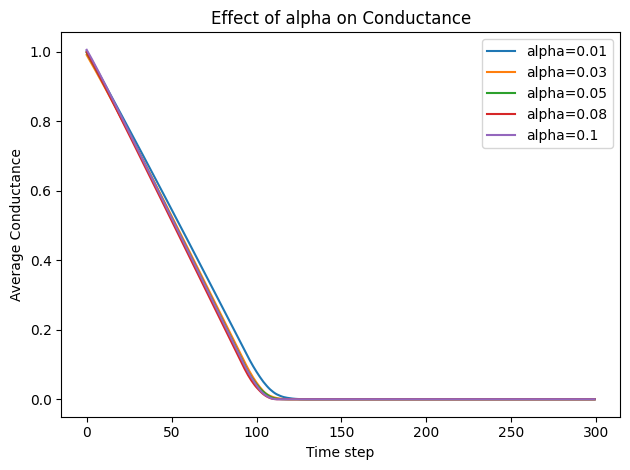

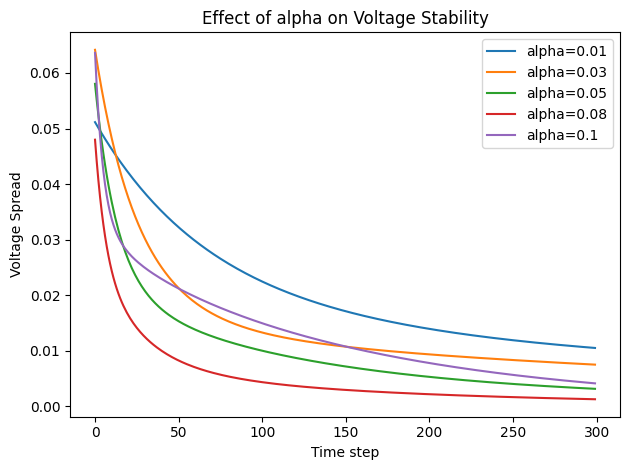

In [14]:
# ---- Test effect of alpha ---- #
alpha_values = [0.01, 0.03, 0.05, 0.08, 0.10]

alpha_results = test_parameter("alpha", alpha_values)
plot_parameter_effect(alpha_results, "alpha")

Running beta = 0.005
Running beta = 0.01
Running beta = 0.02
Running beta = 0.03
Running beta = 0.05


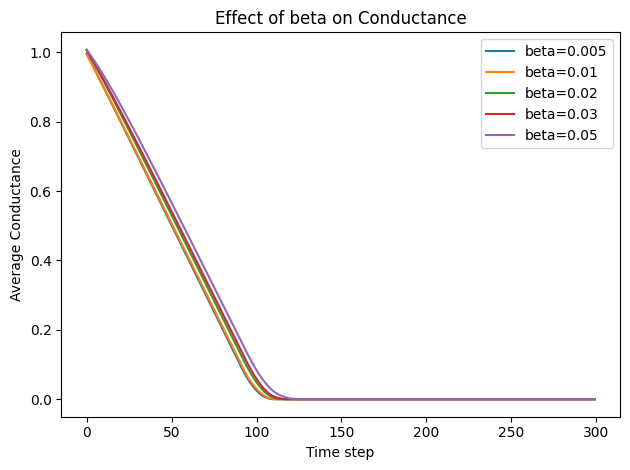

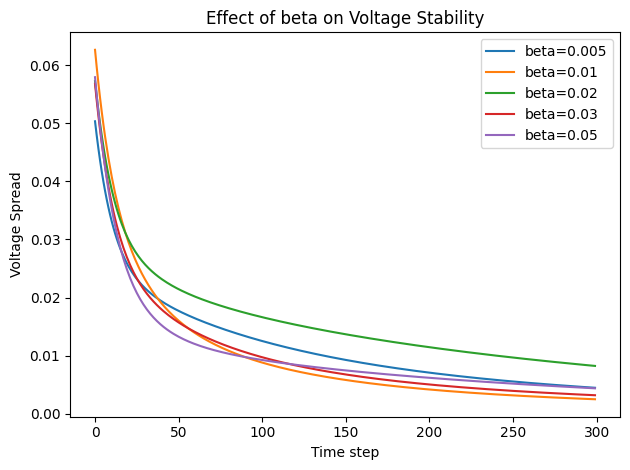

In [15]:
# ---- Test effect of beta ---- #
beta_values = [0.005, 0.01, 0.02, 0.03, 0.05]

beta_results = test_parameter("beta", beta_values)
plot_parameter_effect(beta_results, "beta")

Running gamma = 0.005
Running gamma = 0.01
Running gamma = 0.015
Running gamma = 0.02
Running gamma = 0.03


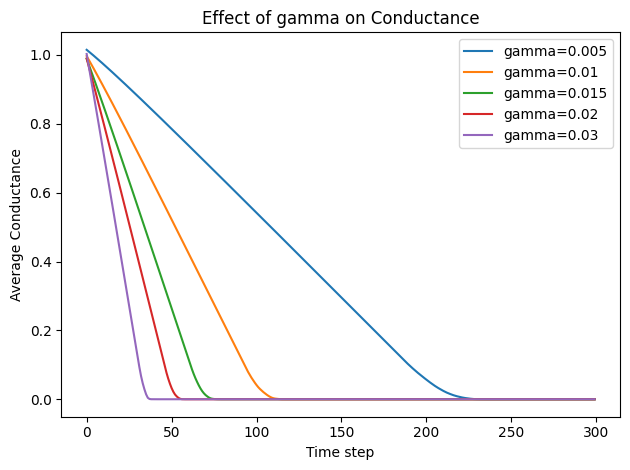

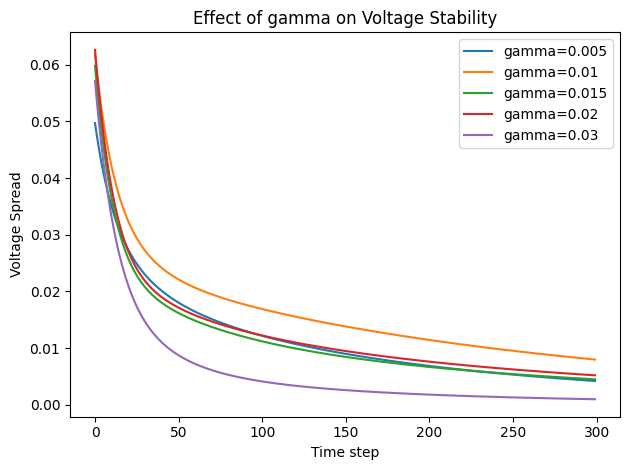

In [16]:
# ---- Test effect of gamma ---- #
gamma_values = [0.005, 0.01, 0.015, 0.02, 0.03]

gamma_results = test_parameter("gamma", gamma_values)
plot_parameter_effect(gamma_results, "gamma")